# Naive persistence forecaster

In [239]:
import pandas as pd
from darts import TimeSeries
from typing import Optional
import numpy as np
from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None
targets = pd.read_csv("targets.csv.gz")
metadata = pd.read_csv('NEON_Field_Site_Metadata_20220412.csv')
metadata = metadata.loc[metadata.aquatics == 1][['field_site_id', 'field_site_subtype', 'field_latitude', 'field_longitude']]

# Performing K-Means clustering
num_clusters = 5

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
metadata['cluster'] = kmeans.fit_predict(metadata[['field_latitude', 'field_longitude']])
region_mapping = {
    0: 'East',
    1: 'Alaska',
    2: 'West',
    3: 'Mid',
    4: 'Puerto Rico'
}
metadata['region'] = metadata['cluster'].map(region_mapping)

/home/rstudio/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [105]:
x = targets.loc[targets.site_id=='ARIK']

In [110]:
class NaivePersistenceForecaster():
    def __init__(self,
                 targets: Optional = None,
                 site_id: Optional[str] = None,
                 target_variable: Optional[str] = "oxygen",
                 forecast_horizon: Optional[int] = 30,
                 validation_split_date: Optional[str] = "2023-03-09",
                 ):
        self.targets = targets.loc[targets.site_id == site_id]
        # Changing the date from a string to a datetime64 object
        column_name = 'datetime'
        column_index = self.targets.columns.get_loc(column_name)
        self.targets[self.targets.columns[column_index]] = pd.to_datetime(self.targets[column_name])
        self.target_variable = target_variable
        self.output_csv_name = output_csv_name
        self.forecast_horizon = forecast_horizon
        self.validation_split_date = validation_split_date
        self.site_id = site_id

    def make_forecasts(self):
        forecast_doys = pd.date_range(
            start=self.validation_split_date, 
            periods=self.forecast_horizon, 
            freq='D',
        )
        # Filter the targets to only look at timestamps before the split date
        date = pd.to_datetime(self.validation_split_date)
        filtered_targets = self.targets.loc[self.targets.datetime < date]
        # Select the last observed target value is selected
        last_row = (
            filtered_targets[filtered_targets[self.target_variable].notna()]
            .iloc[-1]
        )
        last_target_value = last_row[self.target_variable]
        # Create a TimeSeries with this value for each day of the forecast window
        values = np.array([last_target_value for doy in forecast_doys])
        self.forecast_ts = TimeSeries.from_times_and_values(forecast_doys, values)

In [112]:
test = NaivePersistenceForecaster(
    targets,
    site_id='BARC',
)

In [113]:
def modify_score_dict(csv, targets_df, target_variable, site_id, suffix, score_dict):
    try:
        forecast_df = pd.read_csv(csv)
    except:
        return score_dict
    forecast_df["datetime"] = pd.to_datetime(forecast_df["datetime"])
    times = pd.DatetimeIndex(forecast_df["datetime"])
    forecast_df = forecast_df.set_index("datetime")

    # Getting the validation set from targets
    forecast_horizon = len(forecast_df)
    validation_series = get_validation_series(
        targets_df, 
        site_id, 
        target_variable, 
        times[0], 
        forecast_horizon,
    )

    # If there is no validation set at the site skip
    if len(validation_series) == 0:
        return score_dict
    try:
        # This removes entries from the forecast that do not have validation points
        filtered_model_forecast, filtered_validation_series = filter_forecast_df(
            forecast_df, 
            validation_series
        )
    except:
        return score_dict

    # Initialize in case site id is empty at the site
    time_str = times[0].strftime('%Y_%m_%d')
    if time_str not in score_dict:
        score_dict[time_str] = {}
        
    # Computing CRPS and recording
    filtered_validation_ts = TimeSeries.from_times_and_values(
        filtered_validation_series.index, 
        filtered_validation_series.values, 
        fill_missing_dates=True,
        freq='D'
    )

    rmse_score = rmse(filtered_validation_ts, filtered_model_forecast)
    score_dict[time_str]["rmse_forecast"] = rmse_score

    crps_scores = crps(
        filtered_model_forecast, 
        filtered_validation_ts,
        observed_is_ts=True,
    )
    score_dict[time_str]["crps_forecast"] = crps_scores.pd_dataframe().values[:, 0]

    # Instantiating the null models which includes a daily historical and a naive
    # persistence model
    input_dict = {
        'targets': targets_df,
        'site_id': site_id,
        'target_variable': target_variable,
        'output_csv_name': None,
        'validation_split_date': str(times[0])[:10],
        'forecast_horizon': forecast_horizon,
    }
    

    null_models = [
        HistoricalForecaster(**input_dict), 
        NaivePersistenceForecaster(**input_dict)
    ]
    
    # If issue making historical forecasts, then we'll skip.
    try:
        [model.make_forecasts() for model in null_models]
    except:
        del score_dict[time_str]
        return score_dict

    forecast_dfs = [
        model.forecast_ts.pd_dataframe(suppress_warnings=True) \
        for model in null_models
    ]

    # Note that the filter_forecast outputs a tuple with the filtered
    # forecast and the validation series
    filtered_forecasts = [
        filter_forecast_df(forecast_dfs[0], validation_series),
        filter_forecast_df(forecast_dfs[1], validation_series)
    ]

    rmse_scores = [
        rmse(filtered_validation_ts, filtered_forecasts[0][0]),
        rmse(filtered_validation_ts, filtered_forecasts[1][0])
    ]
    
    crps_scores = crps(
            filtered_forecasts[0][0],
            filtered_validation_ts,
            observed_is_ts=True,
    )
    
    score_dict[time_str]["rmse_historical"] = rmse_scores[0]
    score_dict[time_str]["rmse_naive"] = rmse_scores[1]
    score_dict[time_str]["crps_historical"] = crps_scores.pd_dataframe().values[:, 0]
    
    return score_dict

In [216]:
def score_improvement_bysite(model, targets_df, target_variable, suffix="", plot_name=None):
    score_dict = {}
    # For each site, score CRPS and RMSE individually and add to score_dict
    for site_id in targets_df.site_id.unique():
        site_dict = {}
        glob_prefix = f'forecasts/{site_id}/{target_variable}/{model}_{suffix}/forecast*'
        csv_list = sorted(glob.glob(glob_prefix))
        for csv in csv_list:
            site_dict = modify_score_dict(
                csv, 
                targets_df, 
                target_variable, 
                site_id, 
                suffix, 
                site_dict
            )
        score_dict[site_id] = site_dict

    # Producing a dataframe from the score dictionary, as df's are easier
    # to manipulate
    df = make_df_from_score_dict(score_dict)

    # Using the mean CRPS score over the forecast horizon
    df = df.groupby(['site_id', 'date', 'metric', 'model']).mean().reset_index()

    # Creating a CRPS and RMSE dataframe separately which is definitely
    # not the most elegant solution here
    crps_df = df[df['metric'] == 'crps']
    rmse_df = df[df['metric'] == 'rmse']
    
    forecast_dfs = [df_[df_['model'] == 'forecast'] for df_ in [crps_df, rmse_df]]
    historical_dfs = [df_[df_['model'] == 'historical'] for df_ in [crps_df, rmse_df]]
    naive_df = df[df['model'] == 'naive']
    naive_df = naive_df.rename(columns={'value': 'value_naive'})

    # Merge the two DataFrames on site_id, date, and metric
    crps_merged = pd.merge(
        forecast_dfs[0], 
        historical_dfs[0], 
        on=['site_id', 'date', 'metric'], 
        suffixes=('_forecast', '_historical')
    )

    rmse_merged = pd.merge(
        forecast_dfs[1], 
        historical_dfs[1], 
        on=['site_id', 'date', 'metric'], 
        suffixes=('_forecast', '_historical')
    )

    rmse_merged = pd.merge(
        rmse_merged, 
        naive_df, 
        on=['site_id', 'date', 'metric'], 
    )
    # Need to finish things up here, basically repeat the below but with the now two dataframes for crps and rmse
    # Calculate percent improvement for each metric
    crps_merged['percent_improvement_historical_crps'] = (
        (crps_merged['value_historical'] - crps_merged['value_forecast']) /
        crps_merged['value_historical']
    ) * 100
    
    rmse_merged['percent_improvement_historical_rmse'] = (
        (rmse_merged['value_historical'] - rmse_merged['value_forecast']) /
        rmse_merged['value_historical']
    ) * 100
    
    rmse_merged['percent_improvement_naive_rmse'] = (
        (rmse_merged['value_naive'] - rmse_merged['value_forecast']) /
        rmse_merged['value_naive']
    ) * 100

    rmse_merged['percent_improvement_nh_rmse'] = (
        (rmse_merged['value_naive'] - rmse_merged['value_historical']) /
        rmse_merged['value_naive']
    ) * 100

    # Finding the amount of windows where the mean crps or rmse has a positive improvement
    crps_merged['positive_improvement_historical_crps'] = (
        crps_merged['percent_improvement_historical_crps'] > 0
    )
    rmse_merged['positive_improvement_historical_rmse'] = (
       rmse_merged['percent_improvement_historical_rmse'] > 0 
    )
    rmse_merged['positive_improvement_naive_rmse'] = (
        rmse_merged['percent_improvement_naive_rmse'] > 0
    )
    rmse_merged['positive_improvement_nh_rmse'] = (
        rmse_merged['percent_improvement_nh_rmse'] > 0
    )

    # Deleting unnecessary columns
    rmse_merged = rmse_merged.drop(rmse_merged.filter(like='model').columns, axis=1)
    rmse_merged = rmse_merged.drop(rmse_merged.filter(like='value').columns, axis=1)
    crps_merged = crps_merged.drop(crps_merged.filter(like='model').columns, axis=1)
    crps_merged = crps_merged.drop(crps_merged.filter(like='value').columns, axis=1)

    # Joining the two df's along site id and date then adding a combined improvement column
    # for comparison against the climatology model
    merged_df = pd.merge(crps_merged, rmse_merged, on=['site_id', 'date'], how='inner')
    merged_df = merged_df.drop(merged_df.filter(like='metric').columns, axis=1)
    merged_df['combined_improvement_historical'] = (
       merged_df['positive_improvement_historical_crps'] &  merged_df['positive_improvement_historical_rmse']
    )
    merged_df['model'] = model
    return merged_df

In [217]:
def make_df_from_score_dict(score_dict):
    # Create lists to store the data
    site_id_list = []
    date_list = []
    metric_list = []
    model_list = []
    value_list = []
    
    # Iterate through the dictionary and extract data
    for site_id, dates in score_dict.items():
        for date, values in dates.items():
            crps_forecast_array = values['crps_forecast']
            crps_historical_array = values['crps_historical']
            rmse_forecast = values['rmse_forecast']
            rmse_historical = values['rmse_historical']
            rmse_naive = values['rmse_naive']
    
            entries = [
                (site_id, date, 'crps', 'forecast', forecast_crps_val)
                for forecast_crps_val in crps_forecast_array
            ] + [
                (site_id, date, 'crps', 'historical', historical_crps_val)
                for historical_crps_val in crps_historical_array
            ] + [
                (site_id, date, 'rmse', 'forecast', rmse_forecast),
                (site_id, date, 'rmse', 'historical', rmse_historical),
                (site_id, date, 'rmse', 'naive', rmse_naive)
            ]
    
            # Extend the lists with the generated entries
            site_id_list.extend([entry[0] for entry in entries])
            date_list.extend([entry[1] for entry in entries])
            metric_list.extend([entry[2] for entry in entries])
            model_list.extend([entry[3] for entry in entries])
            value_list.extend([entry[4] for entry in entries])
    
    # Create a DataFrame
    df = pd.DataFrame({
        'site_id': site_id_list,
        'date': date_list,
        'metric': metric_list,
        'model': model_list,
        'value': value_list
    })
    
    return df

In [218]:
import glob
from plotting_utils import get_validation_series, filter_forecast_df, crps
from darts.metrics import rmse
from utils import (
    BaseForecaster, 
    ResidualForecaster,
    TimeSeriesPreprocessor,
    crps,
    HistoricalForecaster
)

In [220]:
merged_df = score_improvement_bysite('BlockRNN', targets, 'oxygen', suffix='default', )

In [221]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os
from darts import TimeSeries
import glob
import numpy as np
import CRPS.CRPS as forecastscore
from darts.metrics import rmse
import matplotlib as mpl

In [224]:
def plot_forecast(date, targets_df, site_id, target_variable, model_dir, plot_name=None):
    '''
    Returns a plot of the forecast specified by the date and model directory
    in addition to the observed values, the climatology forecast and the naive persistence
    forecast.
    '''
    cmap = mpl.colormaps["tab10"]
    colors = cmap.colors
    # Loading the forecast csv and creating a time series
    csv_name = f"forecasts/{site_id}/{target_variable}/{model_dir}/forecast_{date}.csv"
    df = pd.read_csv(csv_name)
    times = pd.to_datetime(df["datetime"])
    times = pd.DatetimeIndex(times)
    values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((len(times), 1, -1))
    model_forecast = TimeSeries.from_times_and_values(times, 
                                                      values, 
                                                      fill_missing_dates=True, freq="D")
    model_forecast.plot(label=f"{model_dir}", color=colors[0])

    # Getting the validation series directly from the targets csv
    date = model_forecast.time_index[0]
    forecast_horizon = len(model_forecast)
    validation_series = get_validation_series(
        targets_df, 
        site_id, 
        target_variable, 
        date, 
        forecast_horizon
    )

    # Now, making the forecast based off of historical mean and std
    historical_model = HistoricalForecaster(
        targets=targets_df,
        site_id=site_id,
        target_variable=target_variable,
        output_csv_name="historical_forecaster_output.csv",
        validation_split_date=str(model_forecast.time_index[0])[:10],
        forecast_horizon=len(model_forecast),
    )
    historical_model.make_forecasts()
    historical_model.forecast_ts.plot(label="Historical", color=colors[1])
    validation_series.plot(label="Truth", color=colors[2])

    # And the naive forecaster
    naive_model = NaivePersistenceForecaster(
        targets=targets_df,
        site_id=site_id,
        target_variable=target_variable,
        validation_split_date=str(model_forecast.time_index[0])[:10],
        forecast_horizon=len(model_forecast),
    )
    naive_model.make_forecasts()
    naive_model.forecast_ts.plot(label='Naive Persistence', color=colors[3])
    
    x = plt.xlabel("date")
    y = plt.ylabel(target_variable)
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.grid(False)

    # Saving the plot if desired
    if plot_name != None:
        if not os.path.exists(f"plots/{site_id}/{target_variable}/"):
            os.makedirs(f"plots/{site_id}/{target_variable}/")
        plt.savefig(f"plots/{site_id}/{target_variable}/{plot_name}")

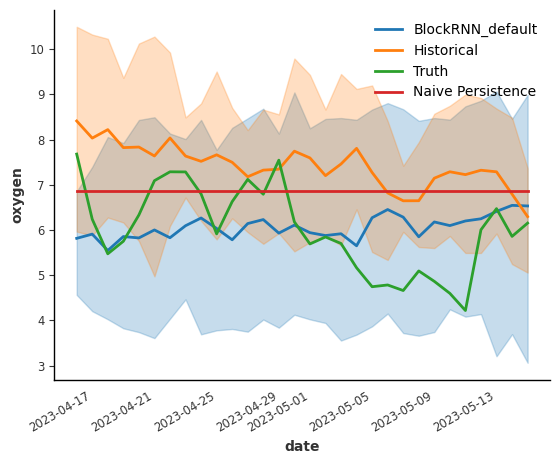

In [235]:
site_id = 'ARIK'
target_variable = 'oxygen'
date = '2023_04_16'
plot_forecast(date, targets, site_id, target_variable, 'BlockRNN_default')

In [227]:
merged_df['date'].unique()

array(['2022_09_18', '2022_10_18', '2022_11_17', '2022_12_17',
       '2023_01_16', '2023_02_15', '2023_03_17', '2023_04_16',
       '2023_05_16', '2023_06_15', '2022_07_20', '2022_08_19'],
      dtype=object)

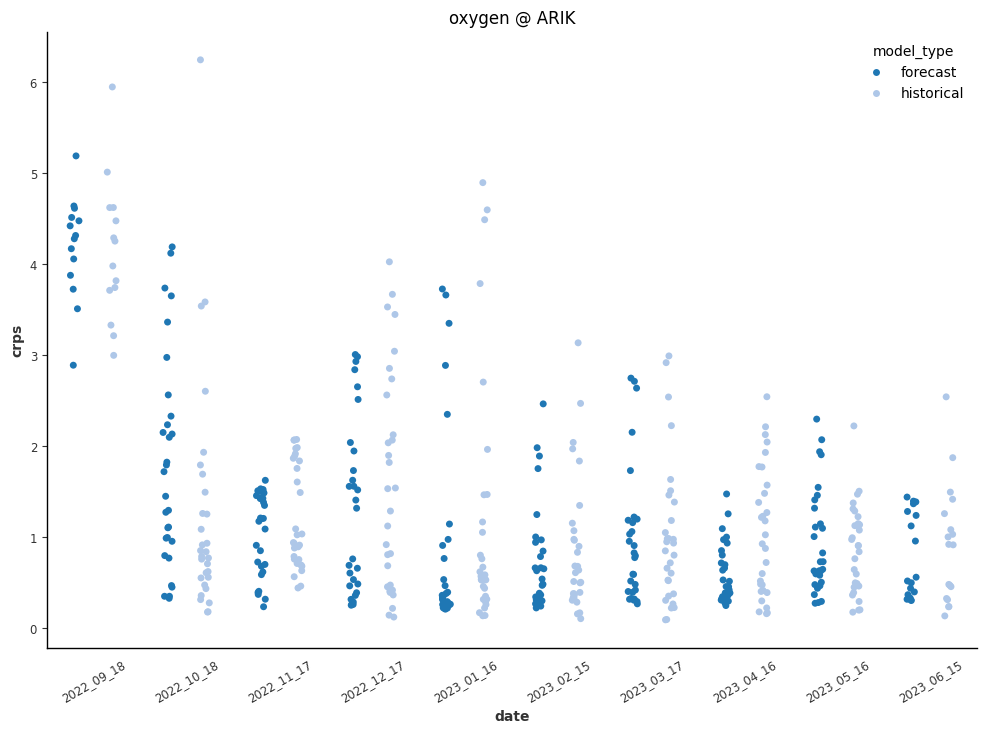

In [236]:
from plotting_utils import plot_crps_bydate
site = 'ARIK'
plot_crps_bydate(f'forecasts/{site}/oxygen/BlockRNN_default/forecast*', targets, site, 'oxygen')

In [246]:
merged_df['positive_improvement_naive_rmse']

0       True
1       True
2      False
3      False
4      False
       ...  
333    False
334    False
335    False
336    False
337     True
Name: positive_improvement_naive_rmse, Length: 338, dtype: bool

In [252]:
def plot_improvement_bysite(score_df, metadata_df, title_name, historical=True):
    '''
    Plots the percent of time the ML model outperforms the historical forecaster
    (historical=True) or the naive persistence model (historical=False)
    '''
    ## Find the percentage of forecast windows during which the ML model excelled 
    ## the historical forecaster
    column = (
        'combined_improvement_historical' if historical \
         else 'positive_improvement_naive_rmse'
    )    
    score_df = score_df[['site_id', column]].groupby(['site_id']).mean() * 100
    score_df.reset_index(inplace=True)
    ## Rename the 'combined_improvement' column to 'combined_improvement_percentage'
    score_df.rename(columns={column: 'improvement_percentage'}, inplace=True)

    ## Marking the sites at which 
    score_df['above_50'] = score_df['improvement_percentage'] > 50

    # Combining df's to include metadata
    df = pd.merge(
        score_df, 
        metadata_df, 
        right_on='field_site_id', 
        left_on='site_id'
    ).drop(columns=['field_site_id'])
    
    plt.figure(figsize=(12, 8))
    custom_palette = {True: 'tab:blue', False: 'indianred'}
    markers = {'Wadeable Stream': 's', 'Lake': 'o', 'Non-wadeable River': '^'}

    for site_type in ['Wadeable Stream', 'Lake', 'Non-wadeable River']:
        
        sns.pointplot(
            data=df.loc[df.field_site_subtype == site_type],
            x='site_id',
            y='improvement_percentage',
            linestyle='',
            hue='above_50',
            palette=custom_palette,
            markers=markers[site_type],
        )

    plt.grid(False)
    comparison_model = "Historical" if historical else "Naive"
    plt.ylabel(f"% of CRPS and RMSE Improvement over {comparison_model}")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    plt.legend(labels=[])
    plt.title(title_name)

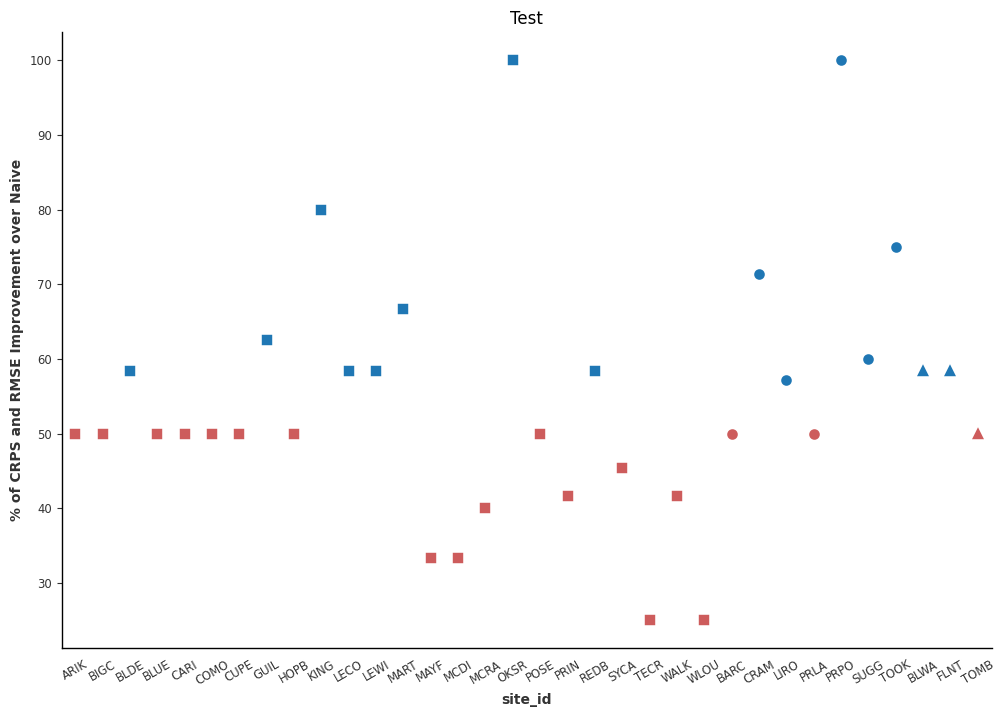

In [253]:
plot_improvement_bysite(merged_df, metadata, 'Test', historical=False)